# Monosynaptic pair analysis
-------

Example notebook demonstrating simple functions in SynapticConn for plotting spike trains. 

In [1]:
import os
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

os.chdir('../..')
print(os.getcwd())

from synapticonn.plots import plot_acg, plot_ccg
from synapticonn.postprocessing import compute_crosscorrelogram, compute_autocorrelogram
from synapticonn.monosynaptic_connections.synaptic_strength import calculate_synaptic_strength

import synapticonn as synapticonn

/Users/michael.zabolocki/Desktop/code/SynaptiConn


Load data. 

In [2]:
data_fpath = pathlib.Path('tests', 'BD0187_spikesorting_array.pkl')

# open pickle
all_units = np.load(data_fpath, allow_pickle=True)
all_units = all_units['spike_time_set']

Set parameters.

In [3]:
srate = 30_000
bin_size_ms = 0.5
max_lag_ms = 25

Initialize the object.

In [4]:
snc = synapticonn.SynaptiConn(all_units, bin_size_ms=1, max_lag_ms=100, srate=30_000, recording_length_ms=600*1000)

Check the loaded spike units.

In [5]:
spk_unit_report = snc.report_spike_units()
pd.DataFrame(spk_unit_report)

,unit_id,n_spikes
0,5,302
1,1,1152
2,0,918
3,16,524
4,17,315
5,18,195
6,15,192
7,4,299
8,3,277


## Spike isolation quality metrics
----

Prior to proceeding, it is important to cross-check the quality of the spike sorted neurons. 

Metrics related to the spike quality can be found below. Notably, the autocorrelograms for each unit should also be cross-referenced prior to continuing. Low contamination (or no contamination) in the refractory periods are important for correct assesments of spike-units and their monosynaptic connections.

**NOTE** here, more simple and core metric assessments are performed. In the future, these will be extended. For further quality metrics, please see the following [code](https://github.com/SpikeInterface/spikeinterface/blob/main/src/spikeinterface/qualitymetrics/misc_metrics.py#L1183). Further, Allen Brain have core documentation which can be found [here](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html#ISI-violations) explaining some key metrics to assess spike unit quality.

In [6]:
params = {'isi_threshold_ms': 1.5,
          'min_isi_ms': 0.3,  # note :: isi min should be based on the miniimum possible refractory period (e.g. spikes removed would constitute this)
          'presence_ratio_bin_duration_ms': 60*1000,
          'presence_ratio_mean_fr_ratio_thresh': 0.0}

qc = snc.spike_unit_quality(**params)
qc

,isi_violations_ratio,isi_violations_rate,isi_violations_count,isi_violations_of_total_spikes,presence_ratio,recording_length_sec,n_spikes,firing_rate_hz
5,0.000000,0.000000,0.0,0.000000,0.909091,600.0,302.0,0.503333
1,0.753520,0.006667,4.0,0.003472,0.909091,600.0,1152.0,1.920000
0,1.186628,0.006667,4.0,0.004357,0.909091,600.0,918.0,1.530000
16,0.000000,0.000000,0.0,0.000000,0.909091,600.0,524.0,0.873333
17,0.000000,0.000000,0.0,0.000000,0.909091,600.0,315.0,0.525000
18,0.000000,0.000000,0.0,0.000000,0.909091,600.0,195.0,0.325000
15,0.000000,0.000000,0.0,0.000000,0.909091,600.0,192.0,0.320000
4,0.000000,0.000000,0.0,0.000000,0.909091,600.0,299.0,0.498333
3,0.000000,0.000000,0.0,0.000000,0.909091,600.0,277.0,0.461667


Filter the spike times for 'good units' based on the quality control metrics.

These will then be used for all further processing. The spike times will be updated accordingly.

A log of the excluded units can be found and kept.

In [7]:
query = 'presence_ratio > 0.5'
good_units = snc.filter_spike_units(qc, query, log=True)
good_units

,isi_violations_ratio,isi_violations_rate,isi_violations_count,isi_violations_of_total_spikes,presence_ratio,recording_length_sec,n_spikes,firing_rate_hz
5,0.000000,0.000000,0.0,0.000000,0.909091,600.0,302.0,0.503333
1,0.753520,0.006667,4.0,0.003472,0.909091,600.0,1152.0,1.920000
0,1.186628,0.006667,4.0,0.004357,0.909091,600.0,918.0,1.530000
16,0.000000,0.000000,0.0,0.000000,0.909091,600.0,524.0,0.873333
17,0.000000,0.000000,0.0,0.000000,0.909091,600.0,315.0,0.525000
18,0.000000,0.000000,0.0,0.000000,0.909091,600.0,195.0,0.325000
15,0.000000,0.000000,0.0,0.000000,0.909091,600.0,192.0,0.320000
4,0.000000,0.000000,0.0,0.000000,0.909091,600.0,299.0,0.498333
3,0.000000,0.000000,0.0,0.000000,0.909091,600.0,277.0,0.461667


Check the updates.

In [8]:
spk_unit_report = snc.report_spike_units()
pd.DataFrame(spk_unit_report)

,unit_id,n_spikes
0,5,302
1,1,1152
2,0,918
3,16,524
4,17,315
5,18,195
6,15,192
7,4,299
8,3,277


## Auto-correlograms
---

Compute the autocorrelogram for select unit IDs.

Plotting autocorrelogram for spike units: [3 1]


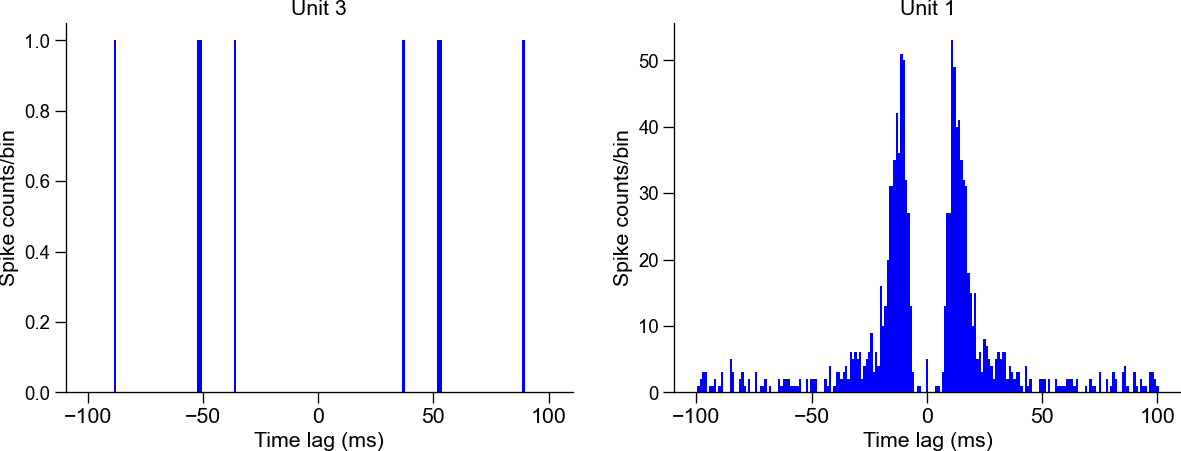

In [9]:
snc.plot_autocorrelogram(spike_units=[3,1,100], color='blue')

Set the bin parameters after initialization, and re-plot.

This can be used to change the binning on the plots, and max time lags.

Plotting autocorrelogram for spike units: [ 0  1 16 17]


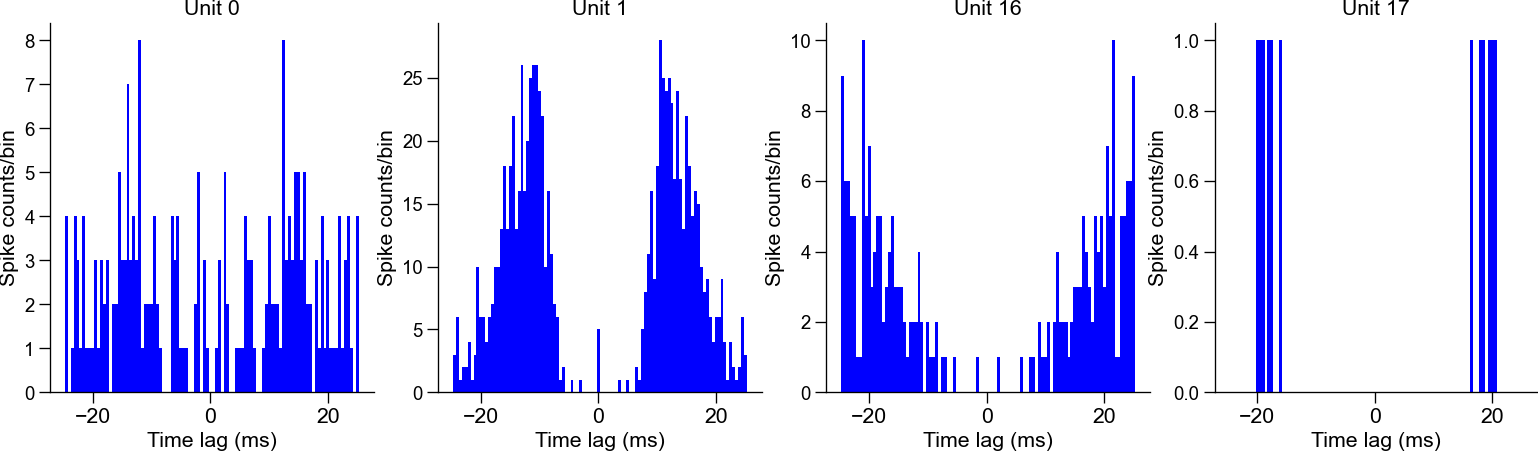

In [10]:
snc.set_bin_settings(bin_size_ms=0.5, max_lag_ms=25)
snc.plot_autocorrelogram(spike_units=[0,1,16,17], color='blue', figsize=(20,5))

## Cross-correlograms
----

Visualize cross-correlograms between pairs.

Bin size and time lag can be changed by re-setting the bins. However, for improved visualizations and reporting a smaller bin size and time lag is recommended.

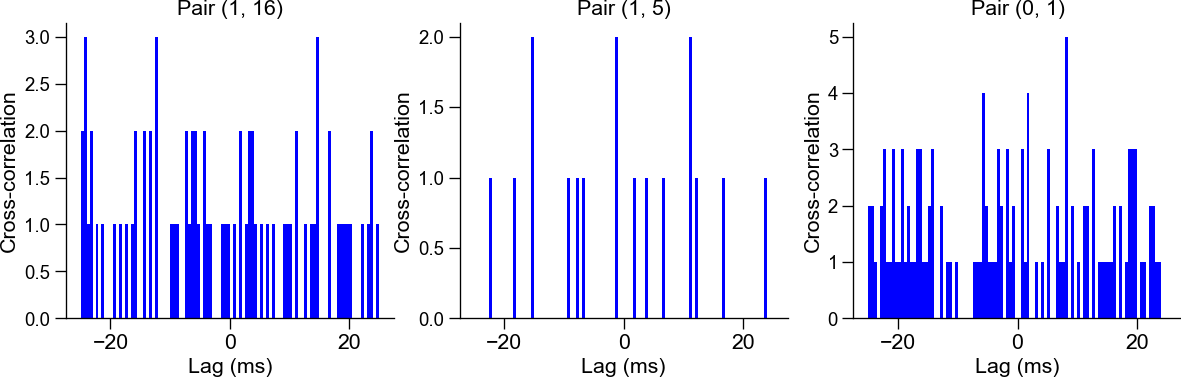

In [11]:
spike_pairs = [(1,16), (1,5), (0,1), (1,16)]
snc.plot_crosscorrelogram(spike_pairs=spike_pairs, figsize=(15, 4))

Alternatively, all possible pairs can be plotted.

In [12]:
# spike_labels = snc.get_spike_unit_labels()

# # get all possible pairs between labels as tuples (including self-pairs)
# spike_pairs = [(i, j) for i in spike_labels for j in spike_labels]
# snc.plot_crosscorrelogram(spike_pairs=spike_pairs, figsize=(20, 30))

## Return correlogram data
----

Next, try returning the correlogram data.

Each key in 'cross_correlations' is indexed by the unit pairs. The corresponding numbers refer to the spike counts, per bin.

Each key in 'bins' is also indexed by the unit pairs. The corresponding numbers refer to the bins edges.

In [13]:
correlogram_data = snc.return_crosscorrelogram_data(spike_pairs=spike_pairs)
correlogram_data

{'cross_correllations': {(1,
   16): array([2, 3, 1, 2, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 0, 2,
         0, 2, 0, 3, 0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 1, 2, 2, 1, 0, 2, 1, 1,
         0, 0, 0, 1, 1, 1, 0, 1, 0, 2, 0, 1, 2, 2, 1, 0, 1, 0, 1, 0, 1, 0,
         0, 0, 1, 1, 1, 0, 2, 0, 0, 1, 0, 1, 1, 3, 0, 0, 0, 2, 0, 0, 1, 1,
         1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 1]),
  (1,
   5): array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
  (0,
   1): array([2, 2, 1, 0, 2, 3, 1, 1, 3, 1, 1, 3, 1, 2, 1, 1, 3, 3, 1, 1, 2, 3,
         0, 0, 2, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 4, 2, 1, 1, 1, 3,
         2, 0, 3, 1, 2, 0, 0, 3, 1, 4, 0, 0, 1, 0, 1, 0, 3, 0, 0, 2, 1, 1,
         5, 0, 2, 0, 1, 

Check the bin settings using for correlogram generations.

In [14]:
snc.report_correlogram_settings()

'Bin size: 0.5 ms, Max lag: 25 ms'

## Compute monosynaptic connections 
----

Compute excitatory and inhibitory monosynaptic connections between spike trains. 

This analysis was based on the following reference by Najafi et al., [here](https://www.sciencedirect.com/science/article/pii/S0896627319308487).

Compute synaptic strength for set paris of neuron IDs.

Note, this adds an instance to the class which is used for further processing.

In [15]:
synaptic_strength_data = snc.synaptic_strength(spike_pairs=spike_pairs, num_iterations=1000, jitter_range_ms=10)

Inspect the output synaptic strength data.

Note that the output contains the following keys: 
1. ccg bins
2. ccg counts (from original spike trains)
3. ccg counts (post jitter)
4. synaptic strength
5. high confidence interval (99%)
6. low confidence interval (1%)

Check the synaptic strength data for a select pair.

This can be done automatically by plotting the original ccg, and the z-scored value.

In [29]:
snc.pair_synaptic_strength.keys()

dict_keys([(1, 16), (1, 5), (0, 1)])

In [43]:
pair = (1, 16)

In [55]:
snc.pair_synaptic_strength[pair].keys()

dict_keys(['ccg_bins', 'original_ccg_counts', 'jittered_ccg_counts', 'high_ci', 'low_ci', 'synaptic_strength', 'jittered_window_counts', 'window_high_ci', 'window_low_ci', 'window_slice'])

In [60]:
window_slice

slice(40, 61, None)

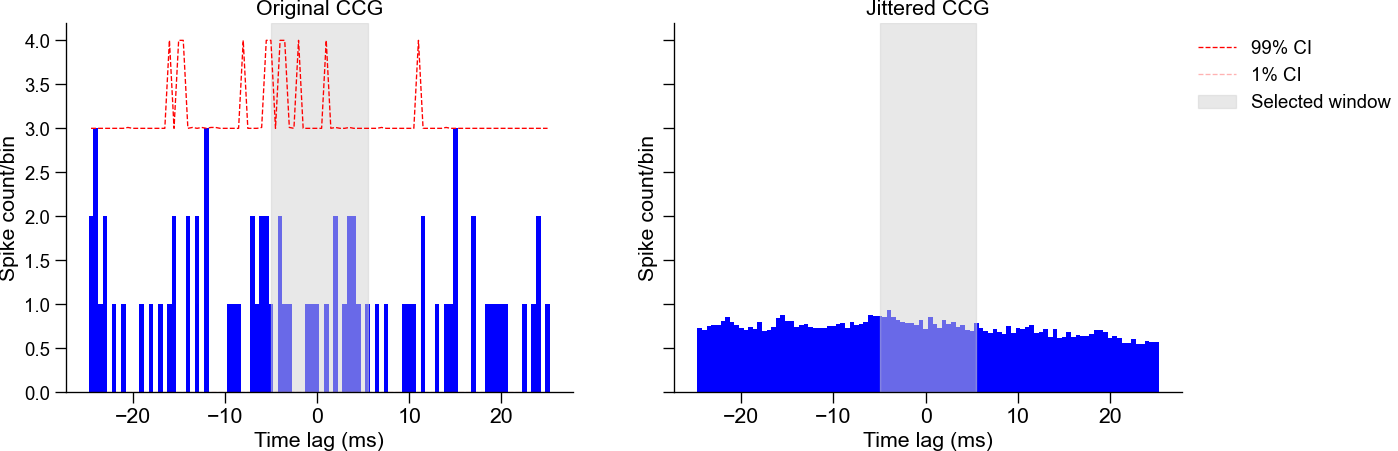

In [85]:
# unpack data
ccg_bins = snc.pair_synaptic_strength[pair]['ccg_bins']
ccg_data = snc.pair_synaptic_strength[pair]['original_ccg_counts']
jittered_ccg_counts = snc.pair_synaptic_strength[pair]['jittered_ccg_counts']
jittered_ccg_window_counts = snc.pair_synaptic_strength[pair]['jittered_window_counts']
high_ci = snc.pair_synaptic_strength[pair]['high_ci']
low_ci = snc.pair_synaptic_strength[pair]['low_ci']
window_high_ci = snc.pair_synaptic_strength[pair]['window_high_ci']
window_low_ci = snc.pair_synaptic_strength[pair]['window_low_ci']
window_slice = snc.pair_synaptic_strength[pair]['window_slice']
sliced_bins = ccg_bins[window_slice]

# plot
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
ax[0].bar(ccg_bins[1:], ccg_data, width=0.5, color='blue')
ax[1].bar(ccg_bins[1:], jittered_ccg_counts.mean(axis=0), width=0.5, color='blue')
ax[0].plot(ccg_bins[1:], high_ci, color='red', alpha=1, ls='--', label='99% CI')
ax[0].plot(ccg_bins[1:], low_ci, color='red', alpha=0.3, ls='--', label='1% CI')

# place box around the window as a visual aid using rectangle
# and center the rectangle around zero
for i in range(2):
    ymin, ymax = ax[i].get_ylim()
    rect = plt.Rectangle((ccg_bins[window_slice.start], 0), ccg_bins[window_slice.stop] - ccg_bins[window_slice.start], ymax, color='lightgrey', alpha=0.5, label='Selected window')
    ax[i].add_patch(rect)


# titles
ax[0].set_title('Original CCG')
ax[1].set_title('Jittered CCG')

# axis labels
ax[0].set_xlabel('Time lag (ms)')
ax[1].set_xlabel('Time lag (ms)')
ax[0].set_ylabel('Spike count/bin')
ax[1].set_ylabel('Spike count/bin')

# show legend
ax[0].legend(bbox_to_anchor=(2.2, 1), loc='upper left')

plt.show()


# ensure that the variable naming is clear for all of these

In [70]:
window_slice.start

40

In [18]:
synaptic_strength_data[spike_pairs[0]]

{'ccg_bins': array([-25. , -24.5, -24. , -23.5, -23. , -22.5, -22. , -21.5, -21. ,
        -20.5, -20. , -19.5, -19. , -18.5, -18. , -17.5, -17. , -16.5,
        -16. , -15.5, -15. , -14.5, -14. , -13.5, -13. , -12.5, -12. ,
        -11.5, -11. , -10.5, -10. ,  -9.5,  -9. ,  -8.5,  -8. ,  -7.5,
         -7. ,  -6.5,  -6. ,  -5.5,  -5. ,  -4.5,  -4. ,  -3.5,  -3. ,
         -2.5,  -2. ,  -1.5,  -1. ,  -0.5,   0. ,   0.5,   1. ,   1.5,
          2. ,   2.5,   3. ,   3.5,   4. ,   4.5,   5. ,   5.5,   6. ,
          6.5,   7. ,   7.5,   8. ,   8.5,   9. ,   9.5,  10. ,  10.5,
         11. ,  11.5,  12. ,  12.5,  13. ,  13.5,  14. ,  14.5,  15. ,
         15.5,  16. ,  16.5,  17. ,  17.5,  18. ,  18.5,  19. ,  19.5,
         20. ,  20.5,  21. ,  21.5,  22. ,  22.5,  23. ,  23.5,  24. ,
         24.5,  25. ]),
 'original_ccg_counts': array([2, 3, 1, 2, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 2, 0, 0, 2,
        0, 2, 0, 3, 0, 0, 0, 0, 1, 1, 1, 0, 0, 2, 1, 2, 2, 1, 0, 2, 1, 1,
        0, 0

**Next, check the connection type.** 

Here, we can perform a putative detection using the z-score (synaptic strength) output.

Thresholds should be set as > 5 for excitatory-connections, or inhibitory connections as < -5 based on the reference protocol.

In [19]:
connection_types = snc.monosynaptic_connection_types(threshold = 5)

# excitatory monosynaptic connections
df = pd.DataFrame(list(connection_types.items()), columns=["Neuron Pair", "Monosynaptic Connection Type"])
df

,Neuron Pair,Monosynaptic Connection Type
0,"(1, 16)",undefined
1,"(1, 5)",undefined
2,"(0, 1)",undefined


Check the ACG quality.

In [20]:
# from collections import namedtuple

# # Define a named tuple type called 'Point' with fields 'x' and 'y'
# res = namedtuple("isi_violation", ["isi_violations_ratio", "isi_violations_count"])  # these are immutable!!!! 

# p = res(isi_violations_ratio=0.5, isi_violations_count=5)
# p

Output a features dataframe containing selected spike pairs.

Plot the CCGs for all pairs, and label their monosynaptic connections.

Here, this can be done quickly using groupped feature modules.

## Validate connection type using waveform classifications
-----

Connection types are putatively based on CCG profiles. However, they should be cross-validated with waveform shapes and/or properties.

For example, an excitatory neuron synapsed to a inhibitory interneuron, or two excitatory neurons are most likely to confer a excitatory-excitatory connection type. 

In such cases, neuron types can be postulated based on the waveforms alone, or additional firing properties, or even ACG profiles. 

## Cross-check electrode distances
-----

## TO DO:
-----

- Make sure there is a clear white sheet etc. for the jitter and statistics --> maybe make this into a doc?

- Can you integrate it to map the connections between cells?

- Place an option for the bin size and time lag in the plotting functions? Or fine as is, because then can streamline all processing here

- Make a JSON output --> export module for the dataset! This will be then easier to load --> make another option to batch-process and visualize multiple datasets etc. etc.

- Build in options for plotting using the synaptic strength calculations.

- Make an option to improve the CCG accuracy by checking firing rates etc. etc. etc.

- Any point having multiple plotting options here?

- Plot all the data out

- Make an option to add new data -- therefore clearing the previous data here

- Check this analysis with a DANDI dataset

- Make a simulation model for ccgs and times etc. etc. to test these parameters

- Return ACG data

- Test units

- Style is not being fitted globally --> the decorator is useless?

- Document all the steps in place to check this all out ...

- Option to improve the labels here for the units? Check it with different input types

- Build a core object which allows for batch-processing, but also adds in the srates etc. of the recordings

- Option to cross-check with the distances???

- Option to change individual colors for CCGs?

- Merge the CCG and ACG decorators into one?

- For autocorrelograms:
    - ensure that the input is a list type 
    - add a function to check the lags and the bins for this etc.
    - check whether unit ids can be in str format etc.

- Plot_ccg is computing and then plotssing --> should be separate?

- Analysis for CCG and ACG should be separated?

- Check the CCG binning --> test this!

- Check the type hinting / remove these?